In [89]:
import time
import multiprocessing as mp
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import argparse
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from utils import read_data

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.nbits = 2048
args.kernel = 'rbf'
args.C = 1.0
args.gamma = 'auto'
args.n_splits = 5
args.tox_type = 'nr-ahr'


np.random.seed(args.seed)
list_tox_type = ['nr-ahr', 'nr-ar-lbd', 
                 'nr-ar', 'nr-aromatase', 
                 'nr-er-lbd', 'nr-er', 
                 'nr-ppar-gamma', 'sr-are', 
                 'sr-atad5', 'sr-hse', 
                 'sr-mmp', 'sr-p53']


# Prepare Dataset by Generating Molecular Fingerprints

In [90]:
# Generate bit vector from given smile string
def get_fingerprint(smile, args):
    mol = Chem.MolFromSmiles(smile)
    fingerprint = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=args.nbits)
    bit_string = fingerprint.ToBitString()
    bit_vec = np.array([int(bit) for bit in bit_string])
    return bit_vec
    
# Generate Dataset by shuffling, fingerprinting, spliting
def make_dataset(args):
    smiles, label = read_data(args.tox_type)
    smiles, label = shuffle(smiles, label, random_state=args.seed)
    
    # Convert Smiles to Morgan Fingerprints and exclude failure cases
    list_vec = list()
    list_label = list()
    for i, smile in enumerate(smiles):
        try:
            vec = get_fingerprint(smile, args)
            list_vec.append(vec)
            list_label.append(label[i])
        except:
            pass
    
    return np.array(list_vec), np.array(list_label)

# Visualizing ROC Curve

Reference : http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [91]:
def plot_roc(roc_auc, fpr, tpr, accu):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.3f}) (accu = {:0.3f})'.format(roc_auc, accu))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Experiment Template

Reference : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold  


### Training and Evaluating Model

In [92]:
def train(train_x, train_y, model, args):
    model.fit(train_x, train_y)
    return model

def evaluate(test_x, test_y, model, args):
#     proba_y = model.predict_proba(test_x) # -> Slow down computation speed
    proba_y = model.decision_function(test_x)
    roc_auc = roc_auc_score(test_y, proba_y) # proba_y[:, 1] when using predict_proba
    fpr, tpr, _ = roc_curve(test_y, proba_y) # proba_y[:, 1] when using predict_proba
    
    predict_y = model.predict(test_x)
    accu = accuracy_score(test_y, predict_y)
    return accu, roc_auc, fpr, tpr

In [93]:
def experiment(x_train, y_train, x_test, y_test, args):
    if args.kernel == 'linear':
        model = LinearSVC(C=args.C)
    else:
        model = SVC(C=args.C, 
                    kernel=args.kernel, 
                    gamma=args.gamma, 
                    verbose=False, 
                    probability=False)
    model = train(x_train, y_train, model, args)
    accu, roc_auc, fpr, tpr = evaluate(x_test, y_test, model, args)
    return accu, roc_auc, fpr, tpr

In [94]:
def kfold_experiment(dataset, args):    
    list_accu = list()
    list_roc_auc = list()
    for x_train, y_train, x_test, y_test in dataset:
        
        accu, roc_auc, fpr, tpr = experiment(x_train, y_train, x_test, y_test, args)
        list_accu.append(accu)
        list_roc_auc.append(roc_auc)
    
    return np.array(list_accu).mean(), np.array(list_roc_auc).mean()

In [95]:
def subproc_experiment(args):
    ts = time.time()

    X, y = make_dataset(args)
    list_fold = list()
    cv = StratifiedKFold(n_splits=args.n_splits)
    for train_index, test_index in cv.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Handling class imbalnce problem by oversampling toxic data using SMOTE algorithm 
        sm = SMOTE(ratio='auto', kind='regular')
        x_train, y_train = sm.fit_sample(x_train, y_train) 
        list_fold.append((x_train, y_train, x_test, y_test))

    mean_accu, mean_roc_auc = kfold_experiment(list_fold, args)
    te = time.time()
    result = {"roc_auc":mean_roc_auc, "accu":mean_accu, 'elapsed':te-ts}
    temp_args = vars(args)
#     del temp_args['dataset']
    result.update(temp_args)
    return result
    
def callback_experiment(result):
    result = deepcopy(result)    
    output = "Exp. {} bits. Mean Accu: {:0.3f} Mean ROC_AUC: {:0.3f} Elapsed: {:3.1f}"
    output = output.format(result['nbits'], 
                            result['accu'],
                            result['roc_auc'],
                            result['elapsed'])
    print(output)
    
    global exp_data
    list_experiments = exp_data.get(args.exp_name, [])
    list_experiments.append(result)

In [96]:
exp_data = dict()

# Experiemnt1. Effect of nbits

In this experiment, molecular fingerprints would be calculated with different nbits values. If the value of the nbits is too low, then fingerprint vector would not represent important information. Otherwise, if the value of the nbits is too high, then fingerprint vector would be sparse so that model would less capture important feature from the fingerprint vector  

Data Handling Ref : http://pbpython.com/pandas-list-dict.html  
Linear SVC Ref : http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html  
SVC Ref : http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
%%time

args.kernel = 'linear'
args.seed = 123
args.C = 1.0
args.gamma = 'auto'
args.n_splits = 5
args.exp_name = 'exp_nbits'

exp_data['exp_nbits'] = list()
list_nbits = [1, 4, 16, 64, 256, 1024, 2048, 4096]#, 8192]

pool = mp.Pool(processes=14)
for tox_type in list_tox_type[:]:
    for nbits in list_nbits:
        args.tox_type = tox_type
        args.nbits = nbits
        pool.apply_async(subproc_experiment, args = (deepcopy(args),), callback=callback_experiment)

pool.close()
pool.join()

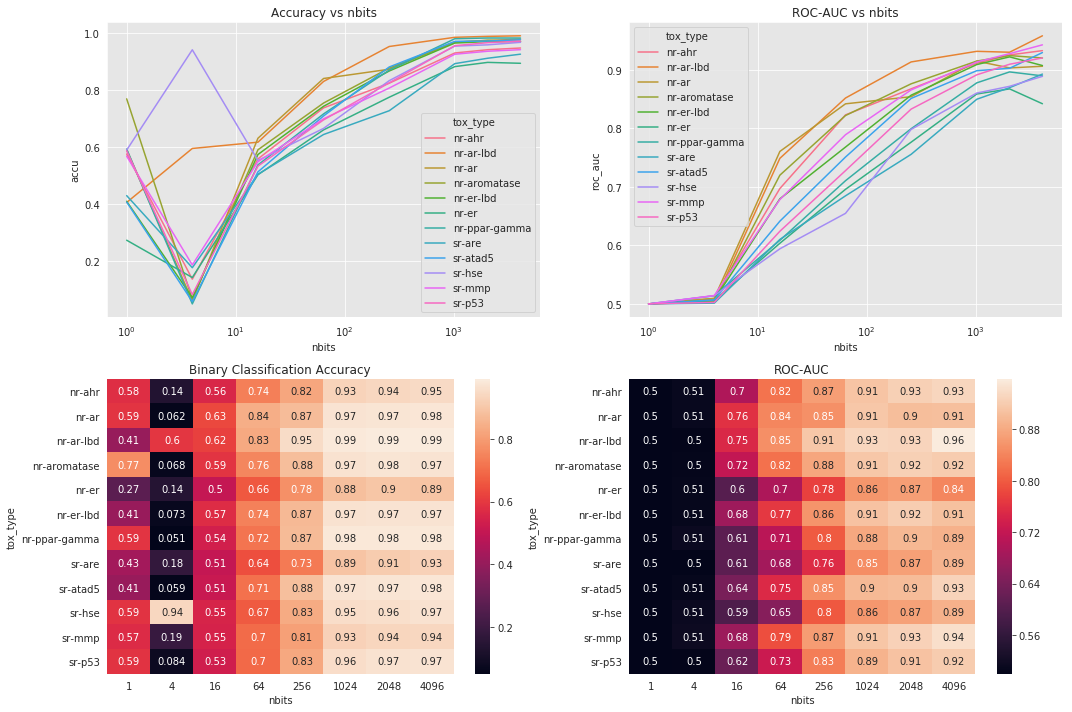

In [36]:
df = pd.DataFrame(exp_data['exp_nbits'])
df = df[['accu', 'roc_auc', 'nbits', 'tox_type']]

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="nbits", y="accu", hue="tox_type", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs nbits")
grid.set(xscale="log")
grid.grid(True)

grid = sns.lineplot(x="nbits", y="roc_auc", hue="tox_type", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs nbits")
grid.set(xscale="log")
grid.grid(True)

df_accu = df.pivot(index='tox_type', columns='nbits', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='tox_type', columns='nbits', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

plt.tight_layout()
plt.grid(True)

# Experiment2. Effect of Kernel

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.gamma = 'auto'
args.n_splits = 5
args.exp_name = 'exp_kernel'

exp_data['exp_kernel'] = list()
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for tox_type in list_tox_type[:1]:
    for kernel in list_kernel:
        args.tox_type = tox_type
        args.kernel = kernel
        pool.apply_async(subproc_experiment, args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

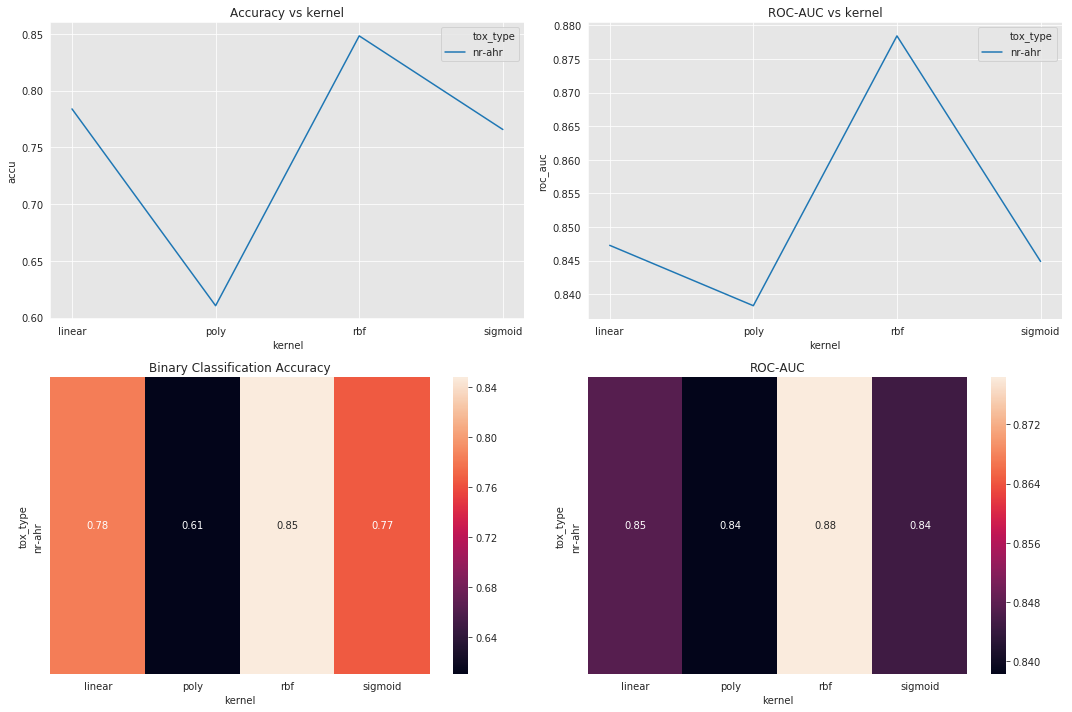

In [11]:
df = pd.DataFrame(exp_data['exp_kernel'])
df = df[['accu', 'roc_auc', 'kernel', 'tox_type']]

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="kernel", y="accu", hue="tox_type", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs kernel")
grid.grid(True)

grid = sns.lineplot(x="kernel", y="roc_auc", hue="tox_type", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs kernel")
grid.grid(True)

df_accu = df.pivot(index='tox_type', columns='kernel', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='tox_type', columns='kernel', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

plt.tight_layout()
plt.grid(True)

# Experiment3. Effect of 'C' coef of SVC

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.gamma = 'auto'
args.n_splits = 5
args.kernel = 'poly'
args.exp_name = 'exp_C'
args.tox_type = 'nr-ahr'

exp_data['exp_C'] = list()
list_C = [ i for i in range(1, 40, 3)]
list_kernel = ['poly', 'linear', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for kernel in list_kernel[:]:
    for C in list_C:
        args.kernel = kernel
        args.C = C
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

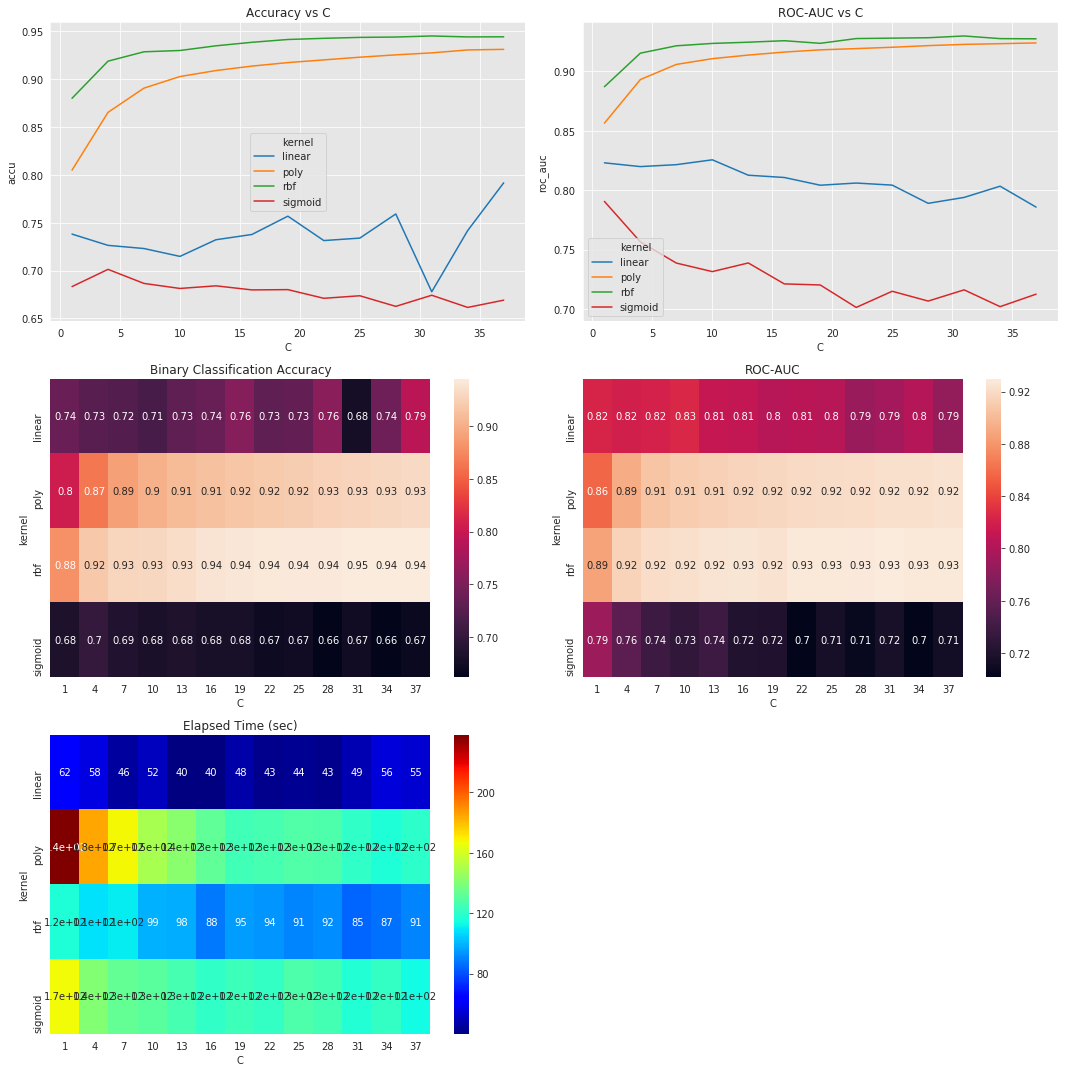

In [86]:
df = pd.DataFrame(exp_data['exp_C'])
df = df[['accu', 'roc_auc', 'C', 'kernel', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="C", y="accu", hue="kernel", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs C")
grid.grid(True)

grid = sns.lineplot(x="C", y="roc_auc", hue="kernel", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs C")
grid.grid(True)

df_accu = df.pivot(index='kernel', columns='C', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='kernel', columns='C', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='kernel', columns='C', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)

# Experiment4. Effect of 'gamma' coef of SVC

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.n_splits = 5
args.exp_name = 'exp_gamma'
args.tox_type = 'nr-ahr'

exp_data['exp_gamma'] = list()
list_gamma = [ 10**i for i in range(-4, 5)]
list_kernel = ['poly', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for kernel in list_kernel[:]:
    for gamma in list_gamma:
        args.kernel = kernel
        args.gamma = gamma
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

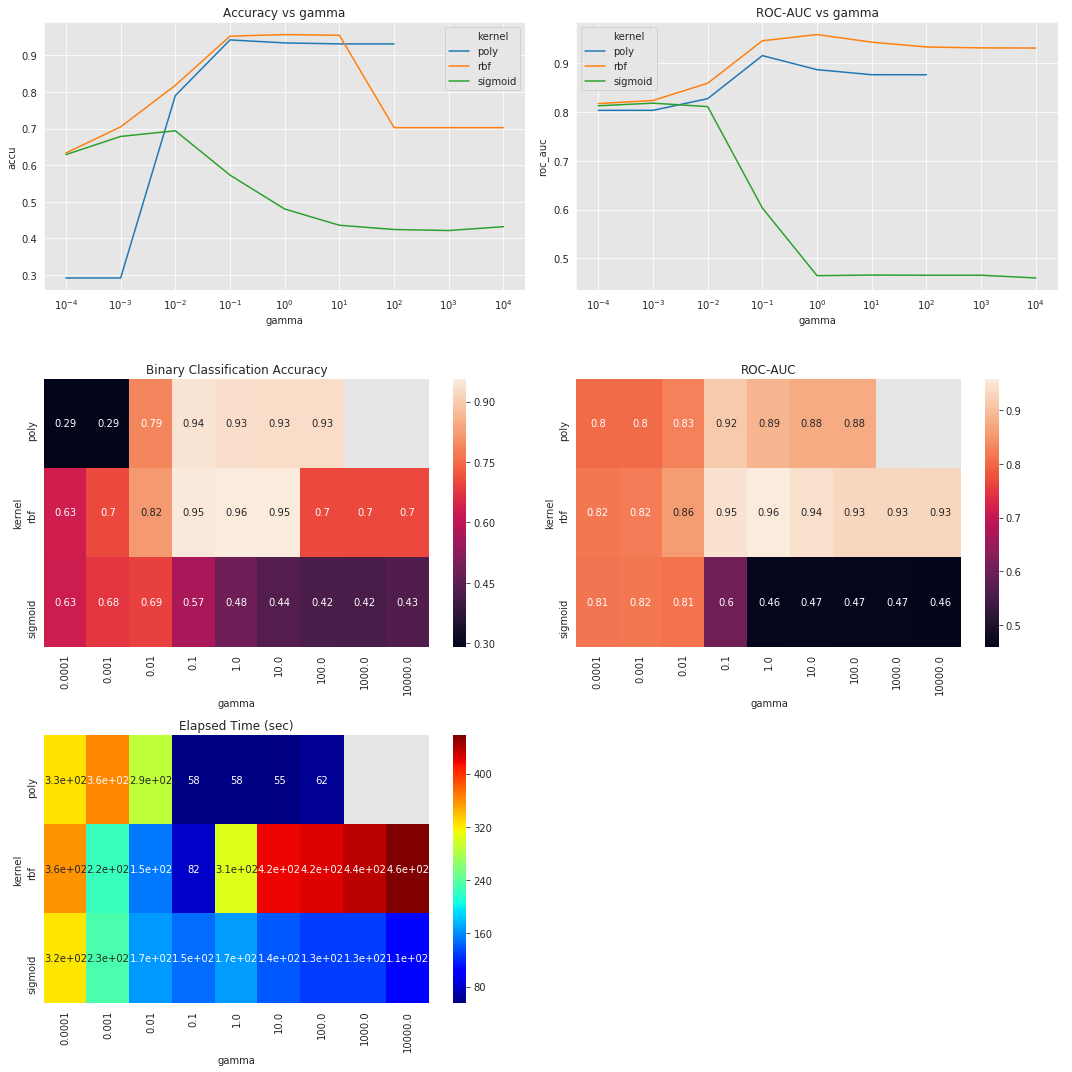

In [83]:
df = pd.DataFrame(exp_data['exp_gamma'])
df = df[['accu', 'roc_auc', 'gamma', 'kernel', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="gamma", y="accu", hue="kernel", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs gamma")
grid.grid(True)
grid.set(xscale="log")

grid = sns.lineplot(x="gamma", y="roc_auc", hue="kernel", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs gamma")
grid.grid(True)
grid.set(xscale="log")

df_accu = df.pivot(index='kernel', columns='gamma', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='kernel', columns='gamma', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='kernel', columns='gamma', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)

# Experiment5. Simultaneous Effect of 'gamma' and 'C' coef of SVC


In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.n_splits = 5
args.exp_name = 'exp_c_gamma'
args.tox_type = 'nr-ahr'
args.kernel = 'rbf'

exp_data['exp_c_gamma'] = list()
list_C = [ 4**i for i in range(-4, 4)]
list_gamma = [ 5**i for i in range(-3, 4)]
print("Total {} Cases".format(len(list_C)*len(list_gamma)))

pool = mp.Pool(processes=14)
for C in list_C[:]:
    for gamma in list_gamma:
        args.C = C
        args.gamma = gamma
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

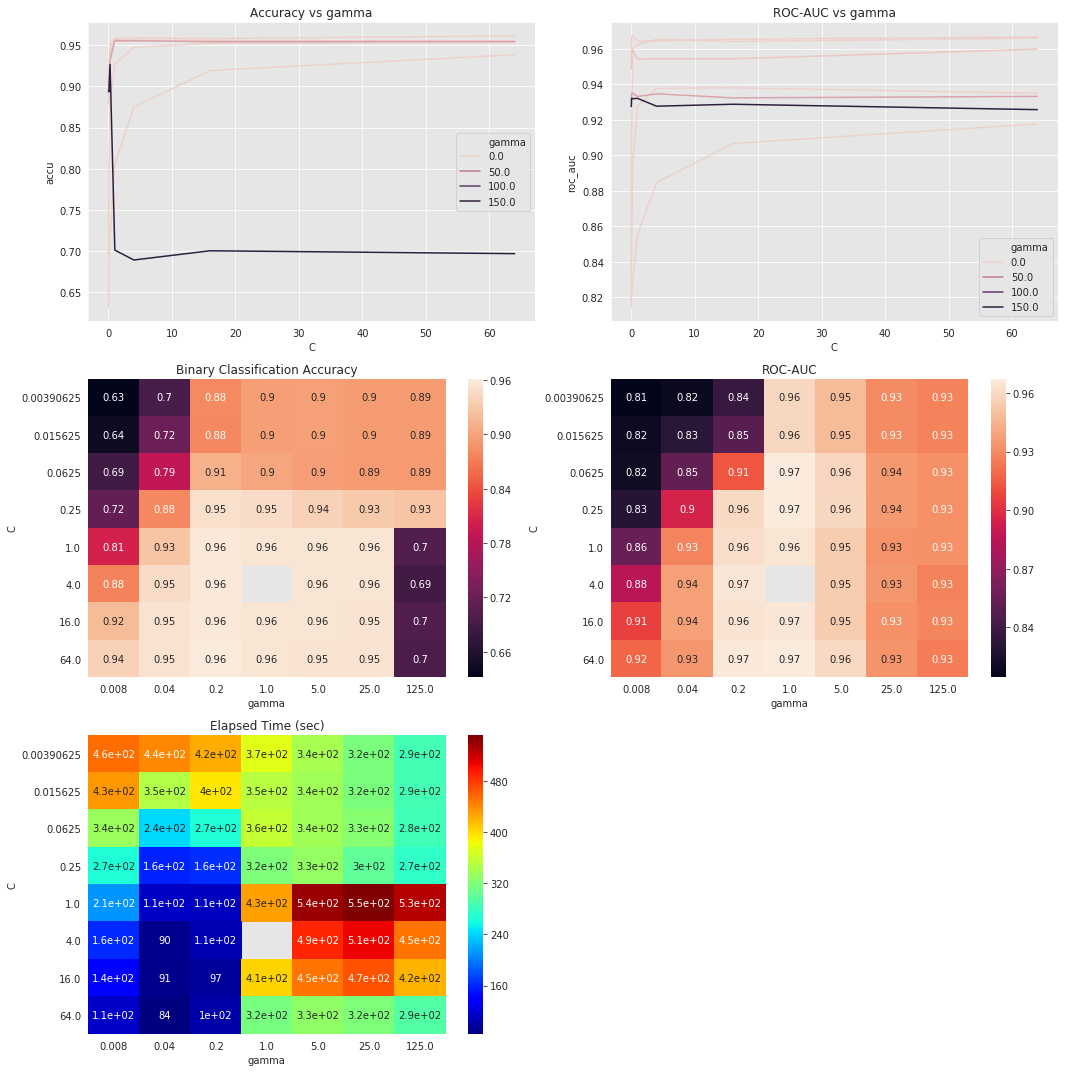

In [84]:
df = pd.DataFrame(exp_data['exp_c_gamma'])
df = df[['accu', 'roc_auc', 'gamma', 'C', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="C", y="accu", hue="gamma", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs gamma")
grid.grid(True)

grid = sns.lineplot(x="C", y="roc_auc", hue="gamma", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs gamma")
grid.grid(True)

df_accu = df.pivot(index='C', columns='gamma', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='C', columns='gamma', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='C', columns='gamma', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')


plt.tight_layout()
plt.grid(True)

In [ ]:
print(5)